# Physics of Stars Computer Project

### Anna Esselink (s4149653)
### Maria Dziouba (s3950425)

In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>")) #Uncomment these lines for fullscreen mode :)

import numpy as np
from matplotlib.pyplot import figure, show, ylim, xscale, vlines
from scipy.interpolate import interp2d
from scipy.integrate import solve_ivp
import seaborn as sns
from collections import OrderedDict

## Abstract

In this project a model of a solar atmosphere was made using data from the Opacity Project [1] and Grevesse & Noels [2] using the Rosseland mean opacity and a grey atmosphere. This results in the opacity as a function of pressure and temperature and temperature, pressure, density and geometrical depth as a function of optical depth. The two data sets were combined using a linear combination. The pressure as a function of optical depth was determined with a Runge-Kutta method integration [3]. This pressure was then used to derive all other variables. These functions were compared to the MARCS stellar atmosphere model. The new model did not deviate much from the MARCS data except for the geometrical depth. The deviations are assumed to be caused by the assumptions of a grey atmosphere and faulty intitial values. The geometrical depth from which most of the radiation eminates was also determined, namely z=2.3e7 cm. The ionisation fraction of hydrogen and helium of the MARCS model were also determined and plotted. 

## Part 1 - Reading & Interpolating Data 

In [3]:
# Loading in data for necessary tables
# This is an "idiot-proof" way of doing it, feel free to do it in a nicer way  - original file is opacity_tables.tab
# Info on the tables also in opacity_tables.tab, so read that

# Tables loaded
opacity_OP_07_002 = np.loadtxt("table_73_edited.txt") 
opacity_OP_07_004 = np.loadtxt("table_75_edited.txt") 
opacity_OP_07_006 = np.loadtxt("table_76_edited.txt") 
opacity_OP_1 = np.loadtxt("table_115_edited.txt")

opacity_OP_07_002 = np.array(opacity_OP_07_002)

# Headers for interpolating (x-axis in table is logR, y-axis is logT)
logT_OP = np.array([3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45, 4.5, 4.55, 4.6, 4.65, 4.7, 4.75, 4.8, 4.85, 4.9, 4.95, 5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0])
logR_OP = np.array([-8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0])

In [4]:
# Interpolating data
sns.set_palette(sns.color_palette("hls", 4))

#f_xyz, where xyz are the composition parameters
f_1 = interp2d(logR_OP, logT_OP, opacity_OP_1) 
f_002 = interp2d(logR_OP, logT_OP, opacity_OP_07_002)
f_004 = interp2d(logR_OP, logT_OP, opacity_OP_07_004)
f_006 = interp2d(logR_OP, logT_OP, opacity_OP_07_006)

#data to reproduce fig 3.17
logT_plot = np.linspace(np.min(logT_OP), np.max(logT_OP), 1000)
logR_plot = -3

opacity_plot_1 = f_1(logR_plot, logT_plot)
opacity_plot_002 = f_002(logR_plot, logT_plot)
opacity_plot_004 = f_004(logR_plot, logT_plot)
opacity_plot_006 = f_006(logR_plot, logT_plot)

# the opacity for Z=0.05 can be approximated by taking the mean of the interpolated
# functions of Z=0.04 and Z=0.06
opacity_plot_005 = np.mean([opacity_plot_004, opacity_plot_006], axis=0)

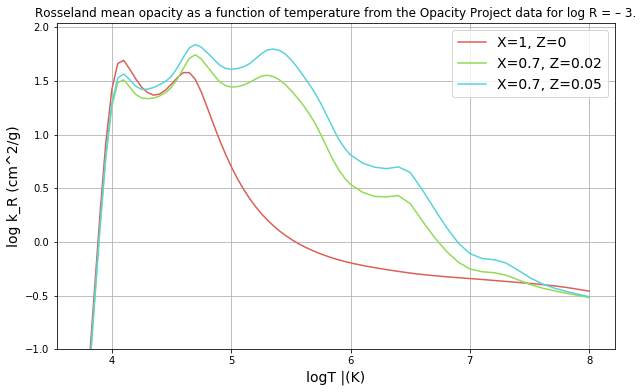

In [68]:
# Plotting data - Plot of κR vs log T

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('logT |(K)', fontsize="14")
fr.set_ylabel('log k_R (cm^2/g)', fontsize="14")
fr.grid(True)
fr.plot(logT_plot, opacity_plot_1,"-", label = "X=1, Z=0")
fr.plot(logT_plot, opacity_plot_002,"-", label = "X=0.7, Z=0.02")
fr.plot(logT_plot, opacity_plot_005,"-", label = "X=0.7, Z=0.05")
#fr.plot(logT_plot, opacity_plot_006,"-", label = "X=0.7, Z=0.06")
fr.set_title("Rosseland mean opacity as a function of temperature from the Opacity Project data for log R = – 3.")
fr.legend(fontsize="14")
ylim(bottom=-1)
show()

The graph above shows the Rosseland mean opacity as a function of temperature for three different metalicities, with R=-3. This is a recreation of fig 3.17 [4]. The green line closest to a solar metallicity. 

### Extension to T, P

To be able to determine the opacity for the pressure we need a function for R in terms of P and T. For this we used equations 3.78 and 5.107 [4]. The density can be written as $\rho=R \cdot T_6^3=R\cdot10^{-18}T^3$. Substituting this into equation 5.107 gives us $P = \frac{\rho k T}{\mu m_H}= \frac{kRT^410^{-18}}{\mu m_H}$. For $\mu$, the mean molecular weight, we took a value of 1.3$m_H$, as this the approximate mean molecular weight for the Sun. This can also be calculated using equation 5.127 and the literary values for the mass fraction of the Sun, using the assumption that all atoms are neutral.  
The function below uses a given log P and log T to calculate the log R, which is then used in the previously interpolated function. The return function can be any of the interpolated functions, but below we used a combined version of a low and high temperature range as this is usefull later on.

In [6]:
def Log_opacity(logP, logT):
    """ Return the log of opacity for a given logP and logR"""
    k = 1.380658e-16  #erg/K Boltzmann constant
    mu = 1.3 #average mass in m_H
    mH = 1.6735344e-24   #g, mass of 1H atom
    logR = -np.log10(k/(mu*mH)) + logP - 4*logT + 18
    return f_opacity(logR, logT)   #function defined in next question

### Extending the Interpolator

The Grevesse and Noels tables are opacity values for the same logR but for a lower tempeature range, 2.75 to 4.5 instead of 3.75 to 8. This data set can be interpolated in the exact same way as the Opacity Project tables.  
In the following section these two sets will be combined using the following linear combination:  
$k(logT)=c_1(logT)\cdot f_{OP}+c_2(logT) \cdot f_{GN}$  
$c_1(logT)=0$ for $logT<3.75$  
$c_2(logT)=1$ for $logT<3.75$  
$c_1(logT)=1$ for $4.5<logT$  
$c_2(logT)=0$ for $4.5<logT$  
In the overlapping regions $c_1$ linearly increases with logT and $c_2$ linearly decreases with logT. This leads to the following equations:  
$c_1=\frac{logT-3.75}{4.5-3.75}$ for $3.75<logT<4.5$  
$c_1=\frac{4.5-logT}{4.5-3.75}$ for $3.75<logT<4.5$  
This leads to that in the low range (2.75 to 3.75) the Grevesse and Noels tables are used, in the high range (4.5 to 8) the Opacity Project tables are used, while in the overlapping region the linear combination is used. This new data set can then be interpolated to create a new function that works for the whole range of logT.

In [7]:
# Load new table, if you want to do this more elegantly the raw table is g7_02.tron
opacity_GN = np.loadtxt("g7_02_edited.tron")
opacity_GN = np.array(opacity_GN)

# Headers for this table
logT_GN = np.array([4.5, 4.45, 4.4, 4.35, 4.3, 4.25, 4.2, 4.15, 4.1, 4.05, 4.0, 3.95, 3.9, 3.85, 3.8, 3.75, 3.7, 3.65, 3.6, 3.55, 3.5, 3.49, 3.48, 3.47, 3.46, 3.45, 3.44, 3.43, 3.42, 3.41, 3.4, 3.39, 3.38, 3.37, 3.36, 3.35, 3.34, 3.33, 3.32, 3.31, 3.3, 3.29, 3.28, 3.27, 3.26, 3.25, 3.24, 3.23, 3.22, 3.21, 3.2, 3.19, 3.18, 3.17, 3.16, 3.15, 3.14, 3.13, 3.12, 3.11, 3.1, 3.09, 3.08, 3.07, 3.06, 3.05, 3.04, 3.03, 3.02, 3.01, 3.0, 2.99, 2.98, 2.97, 2.96, 2.95, 2.94, 2.93, 2.92, 2.91, 2.9, 2.85, 2.8, 2.75, 2.7])
logR_GN = np.array([-8.0, -7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0])

#interpolate Grevesse and Noels tables
f_702_GN = interp2d(logR_GN, logT_GN, opacity_GN)

#array of all logT's from low to high range
logT_new = np.array([2.7,  2.75, 2.8,  2.85, 2.9,  2.95, 3.,   3.05, 3.1,  3.15, 3.2,  3.25, 3.3,  3.35,
 3.4,  3.45, 3.5,  3.55, 3.6,  3.65, 3.7,  3.75, 3.8,  3.85, 3.9,  3.95, 4.,   4.05,
 4.1,  4.15, 4.2,  4.25, 4.3,  4.35, 4.4,  4.45, 4.5,  4.55, 4.6,  4.65, 4.7,  4.75,
 4.8,  4.85, 4.9,  4.95, 5.,   5.05, 5.1,  5.15, 5.2,  5.25, 5.3,  5.35, 5.4,  5.45,
 5.5,  5.55, 5.6,  5.65, 5.7,  5.75, 5.8,  5.85, 5.9,  5.95, 6., 6.1,
 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7., 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.])
#crazyyy bugs in python, so we had to do it this way instead of using
# logT_new = np.arange(2.70, 8.05, step = 0.05)
# logT_new = np.linspace(2.70, 8.05, 108)

# for 2.7<logT<3.75 --> lower T range
# for 3.75<logT<4.5 --> linear combination of low and high
# for 4.5<logT> 8.0 --> high T range

#create array of right amount of collumns to submit rows to
opacity_new = np.zeros(len(logR_OP))

for logT in logT_new:
    #row = list(logT_new).index(logT)
    if logT<= 3.75:  #low range
        row_low = list(logT_GN).index(logT)
        opacity_new = np.vstack((opacity_new, opacity_GN[row_low,:]))
    if logT > 3.75 and logT <= 4.5:  #overlap range
        c1 = (logT-3.75)/(4.5-3.75)    #high range coefficient
        c2 = (4.5-logT)/(4.5-3.75)     #low range coefficient
        row_low = list(logT_GN).index(logT)
        row_high = list(logT_OP).index(logT)
        #linear combination
        opacity_new = np.vstack((opacity_new, c1*opacity_OP_07_002[row_high,:] + c2*opacity_GN[row_low,:]))
    if logT > 4.5:  #high range
        row_high = list(logT_OP).index(logT)
        opacity_new = np.vstack((opacity_new, opacity_OP_07_002[row_high,:]))

#remove first array of only zeros
opacity_new = opacity_new[1:] 

#interpolate over new data set
f_opacity = interp2d(logR_OP, logT_new, opacity_new)

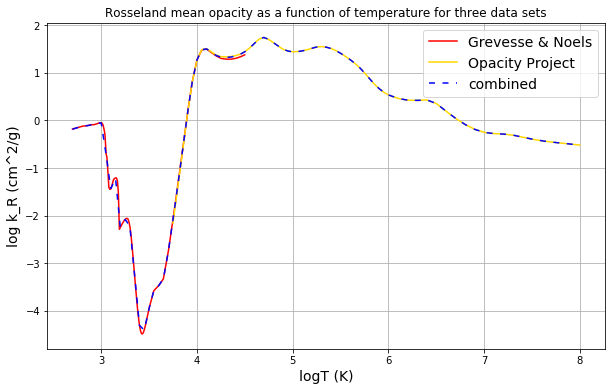

In [69]:
# Plot of log T vs log kappa

logR_plot = -3
logT_plot_GN = np.linspace(np.min(logT_GN), np.max(logT_GN), 1000)
opacity_plot_002_GN = f_702_GN(logR_plot, logT_plot_GN)

logT_plot_new = np.linspace(np.min(logT_new), np.max(logT_new), 1000)
opacity_plot_new = f_opacity(logR_plot, logT_plot_new)

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('logT (K)', fontsize="14")
fr.set_ylabel('log k_R (cm^2/g)', fontsize="14")
fr.grid(True)
fr.plot(logT_plot_GN, opacity_plot_002_GN,"r-", label = "Grevesse & Noels")
fr.plot(logT_plot, opacity_plot_002,"gold", label = "Opacity Project")
fr.plot(logT_plot_new, opacity_plot_new, linestyle=(0, (4,5)), color="b", label = "combined")
fr.legend(fontsize="14")
fr.set_title("Rosseland mean opacity as a function of temperature for three data sets")
show()

The above graph shows the Grevesse and Noels data in red in the left part of the graph and the Opacity Project data in yellow in the right part. Around logT=4 these two sets overlap. The blue dashed line shows the data that interpolated the linearly combined datasets. It smoothly follows the data sets, with no kinks in the overlapping regions. It does smooth out the kinks in the Grevesse and Noels data slightly. This is propably due to the interpolation smoothing this out. 

## Part 2

### Derivation of T as a function of optical depth
  
The first approximation is that the opacity is independent of the frequency, this implies a grey atmosphere. The temperature profile for a grey atmosophere is given by the following equation [4]:  
$T(\tau) = T_{eff}\left[ \frac{3}{4}(\tau + q(\tau))\right]$  
Where $q(\tau)$ is the Hopf function. When it is assumed that most radiation emanated by the Sun comes from the layers of the Sun where photons have a 50% of reaching the surface ($e^{-\tau}=0.5$). Consequently $\tau =2/3$, then using the boandary condition  $T(\tau=2/3)= T_{eff}$, it can be found that $q(\tau) = 2/3$.
Hence the temperature profile that can be adopted in this regime (surface layers, $0.05 \leq \tau \ \leq 2.0$) is:  
$T(\tau) = T_{eff}\left[ \frac{3}{4}(\tau + \frac{2}{3})\right]$  


### Discuss opacity approximation (independent of frequency and given by the Rosseland mean opacity.) (more?)
 
The grey atmosphere is an approximation of the stellar atmosphere that assumes that the opacity is independent of frequency (and wavelength) [4]. This model is not very accurate but does allow for basic properties and the temperature of a star (in this case the Sun) to be determined analytically. The temperature profile that is given above is only valid for the exterior regions/ outer layers of the Sun.
  
The assumption of the Rosseland mean opacity in combinatation with the grey atmosphere implies that the average opacity is equal to the opacity (= Rosseland mean opacity) [4]. 




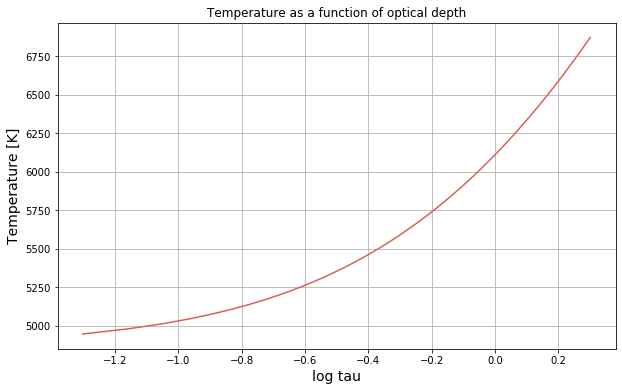

In [9]:
# Plot of T as a function of optical depth for region of interest - think about what you can show as a verification

def Temp(tau):
    """Determine temperature as a function of optical depth
    """
    Teff = 5777 #K, Teff of Sun
    return Teff*(3/4*(tau + 2/3))**0.25 


tau_plot = np.linspace(0.05, 2.0, 100)

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('log tau', fontsize="14")
fr.set_ylabel('Temperature [K]', fontsize="14")
fr.grid(True)
fr.plot(np.log10(tau_plot), Temp(tau_plot),"-")
fr.set_title("Temperature as a function of optical depth")
show()


### Derivation of the equation of hydrostatic equilibrium
Hydrostatic equilibrium [4]:  
$\frac{dP(r)}{dr}=-\rho(r)g$  

Using the definition of the optical depth: $d\tau = -k\rho dz$
Using the notation of that assignment, the opacity is given by $\kappa$ and dz becomes dr. Consequenlty $d\tau = -\kappa\rho dr$
This equation can be rewritten to find:  
$-\rho = \frac{1}{\kappa}\frac{d\tau}{dr}$  

Next this equation can be subsituted in the expression for the hydrostatic equilibrium:  
$\frac{dP(r)}{dr}=\frac{g}{\kappa}\frac{d\tau}{dr}$ 

$\frac{dP(r)}{dr}\frac{dr}{d\tau}=\frac{g}{\kappa}$ 

$\frac{dP}{d\tau}=\frac{g}{\kappa}$  

Using the expression of $\log\kappa$ that is given, an expression for the pressure can be found:  
$\log \kappa = -4.40 + 0.8 \log P_g$  
$\kappa = 10^{-4.40}\cdot P_g^{0.8}$  
Substituting this expression in the derived equation of the hydrostatic equilibrium:  
$\frac{dP}{d\tau}=\frac{g}{10^{-4.40}\cdot P_g^{0.8}}$  
$\int P_g^{0.8} dP = 10^{4.40} g\int d\tau $  
$\frac{1}{1.8} P_g^{1.8}  10^{4.40} g\tau$

$P_g(\tau) = \left(1.8g\tau \cdot10^{4.4} \right)^{5/9}$


### Starting value for pressure

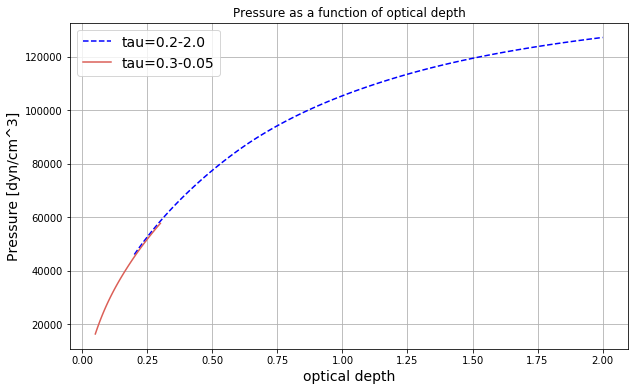

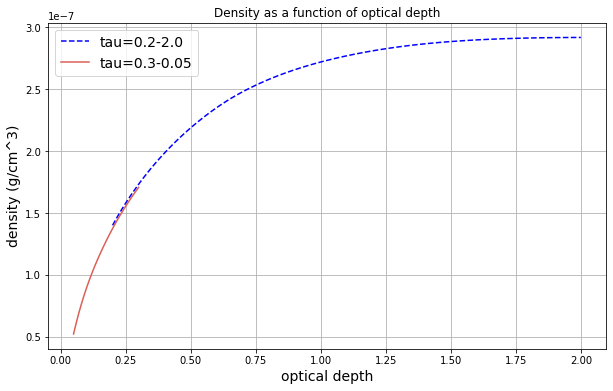

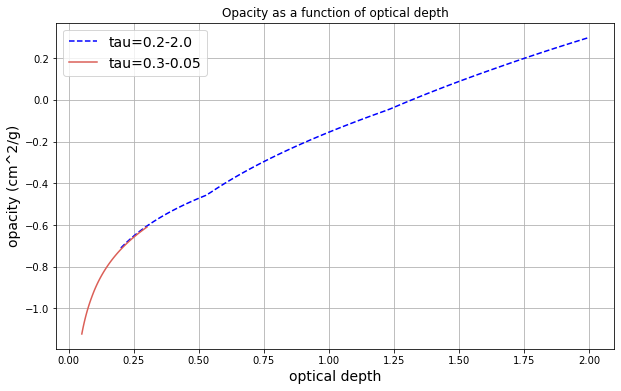

In [77]:
# Integration for starting pressure values

#calculating solar gravitational accelaration
G = 6.67259e-8  # cm^3 g^-1 s^-2
Msol = 1.9891e33  # g
Rsol = 6.95508e10  # cm
g = G*Msol/(Rsol**2)

def Pressure(tau):
    """ Calculate gravitational pressure as a function of optical depth"""
    p = 1.8*g*tau*10**(4.4)
    return p**(5/9)

#starting pressure values
P_02 = Pressure(0.2)
P_03 = Pressure(0.3)

#equation 1 from assignment, over which to integrate
def dPdtau(tau, P):
    """Ordinary differential equation of pressure over optical depth
    """
    logT = np.log10(Temp(tau))
    logP = np.log10(Pressure(tau))
    k = 10**Log_opacity(logP, logT)
    return g/k

tau_02 = np.linspace(0.2,2,100)
tau_03 = np.linspace(0.3,0.05,100)

Solve_02 = solve_ivp(dPdtau, t_span=[0.2, 2.0], y0=[P_02], dense_output=True)
Pprofile_02 = Solve_02.sol(tau_02)[0]

Solve_03 = solve_ivp(dPdtau, t_span=[0.3,0.05], y0=[P_03], dense_output=True)
Pprofile_03 = Solve_03.sol(tau_03)[0]

# Plot of pressure as a function of optical depth.
fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('optical depth', fontsize="14")
fr.set_ylabel('Pressure [dyn/cm^3]', fontsize="14")
fr.grid(True)
fr.plot(tau_02, Pprofile_02, "b--", label='tau=0.2-2.0')
fr.plot(tau_03, Pprofile_03, "-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Pressure as a function of optical depth")
show()

# Plot of density as a function of optical depth
T = 5777 #Teff sun [K]
k = 1.380658e-16  #erg/K Boltzmann constant
mu = 1.3 #average mass in m_H
mH = 1.6735344e-24   #g, mass of 1H atom 
def rho(P,tau):
    """ Calculate density as a function of pressure and optical depth using ideal gas law
    """
    T=Temp(tau)
    return P*mu*mH/(k*T)

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('optical depth', fontsize="14")
fr.set_ylabel('density (g/cm^3)', fontsize="14")
fr.grid(True)
fr.plot(tau_02, rho(Pprofile_02,tau_02), "b--", label='tau=0.2-2.0')
fr.plot(tau_03, rho(Pprofile_03,tau_03), "-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Density as a function of optical depth")
show()

# Plot of opacity as a function of optical depth
kappa_02 = np.zeros(len(tau_02))
kappa_03 = np.zeros(len(tau_03))

#use opacity function made from combined data in part 1
for i in range(len(tau_02)):
    kappa_02[i]=Log_opacity(np.log10(Pprofile_02[i]), np.log10(Temp(tau_02[i])))
    
for i in range(len(tau_03)):
    kappa_03[i]=Log_opacity(np.log10(Pprofile_03[i]), np.log10(Temp(tau_03[i]))) 


fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('optical depth', fontsize="14")
fr.set_ylabel('opacity (cm^2/g)', fontsize="14")
fr.grid(True)
fr.plot(tau_02, kappa_02, "b--", label='tau=0.2-2.0')
fr.plot(tau_03, kappa_03, "-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Opacity as a function of optical depth")
show()

The above graphs show a relativly smooth transition from the integration for $\tau=0.3\: to\: 0.05$ to the integration for $\tau=0.2\: to\: 2.0$. The second range has relativly small offset in the overlapping regions. This might be solved if different starting values are used. To determine the starting values for the pressure approximations were made that are only valid in the range $4\leq log(P) \leq 5$. The equation for this was not used for values outside this range, but a Runge-Kutta method integration [3].

### Relation between the optical depth and the geometrical depth

$d\tau = -\kappa\rho dz$  
$\frac{dz}{dP} = \frac{dz}{d\tau}\frac{d\tau}{dP}$

The first equation can be rewritten to find: $\frac{dz}{d\tau} = -\frac{1}{\kappa\rho}$.  
The hydrostatic equilibrium gives $\frac{d\tau}{dP} = \frac{\kappa}{g}$

Hence $\frac{dz}{dP}$ is found to be: $\frac{dz}{dP} =-\frac{1}{\kappa\rho}\frac{\kappa}{g}  = - \frac{1}{\rho g}$

Except we want to define z as zero at the surface and increasing towards the centre, hence the sign of the expression above changes from - to +.


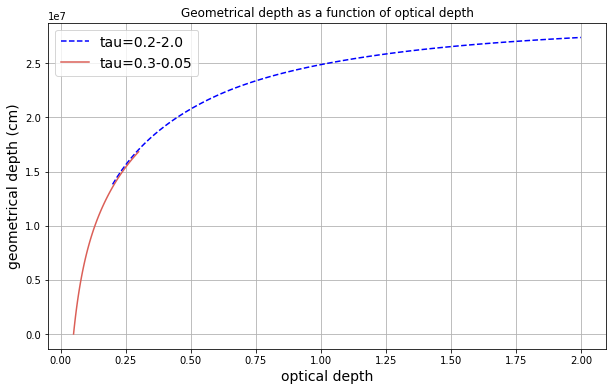

In [66]:
# Integration of equation
T = 5777 #Teff sun [K]
k = 1.380658e-16  #erg/K Boltzmann constant
mu = 1.3 #average mass in m_H
mH = 1.6735344e-24   #g, mass of 1H atom 

tau_01 = np.linspace(0.05,2,1000)

def rho2(P):
    """ Calculate density as a function of pressure using ideal gas law
    """
    return P*mu*mH/(k*T)

def dzdP(P, z):
    """ Ordinary differential equation of geometrical depth over pressure
    """
    return 1/(rho2(P)*g)

init=np.max(Pprofile_02)
final=np.min(Pprofile_03)

Solve_01 = solve_ivp(dzdP, t_span=[final,init], y0=[0], dense_output=True)
z_011 = Solve_01.sol(Pprofile_02)[0]
z_012 = Solve_01.sol(Pprofile_03)[0]

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('optical depth', fontsize="14")
fr.set_ylabel('geometrical depth (cm)', fontsize="14")
fr.grid(True)
fr.plot(tau_02, z_011, "b--", label='tau=0.2-2.0')
fr.plot(tau_03, z_012, "-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Geometrical depth as a function of optical depth")
show()


The above graph shows how optical depth increases with geometrical depth. We defined z=0 at the surface. The graph flattens out when the optical depth dramatically increases at deeper levels. This can be due to the same trend in the density plot seen above. The denser the matter, the more light gets absorbed and scattered, increasing the opaqueness and optical depth.

## Part 3

### Loading in MARCS data

The table **MARCS_solar_model.dat** from Nestor is already loaded for you.

In [12]:
# Extract values from MARCS table
MARCS_k, MARCS_logTau, MARCS_z, MARCS_Temp, MARCS_P_e, MARCS_P_g, MARCS_P_rad, MARCS_P_turb = np.loadtxt('MARCS_solar_model.dat').T


### Plots

Plot your model and the MARCS data on same axes, discuss each plot

### Plot of log tau vs T(tau)

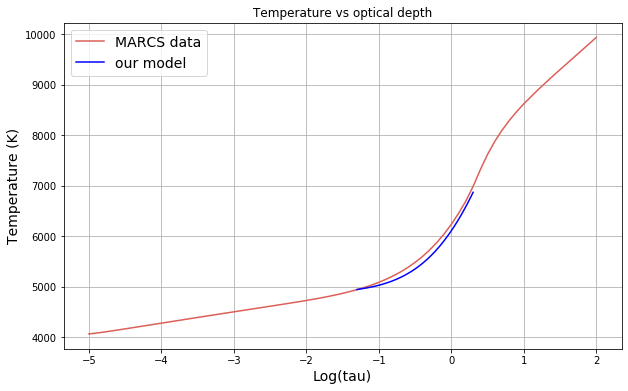

In [13]:
# Plot
fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('Log(tau)', fontsize="14")
fr.set_ylabel('Temperature (K)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, MARCS_Temp, "-", label='MARCS data')
fr.plot(np.log10(tau_plot), Temp(tau_plot),"b-", label='our model')
fr.legend(fontsize='14')
fr.set_title("Temperature vs optical depth")
show()

Discussion of plot:  
The plot shows that the temperature increases as the optical depth increases. Optical depth is a measure of opaqueness of the stellar medium and increases deeper within the star. This is also the case for temperature. Generally the deeper within the star, the hotter. Our model fits the MARCS data pretty well. It matches near the end and beginning of our model, but deviates in the center. The assumptions for our temperature profile were that of a grey atmosphere and that $T(\tau=2/3)=T_{eff}$ [4]. This approximates that the opacity is independent of frequency. It deviates most around values where most of the radiation comes from. 
### Plot of log tau vs P(tau)

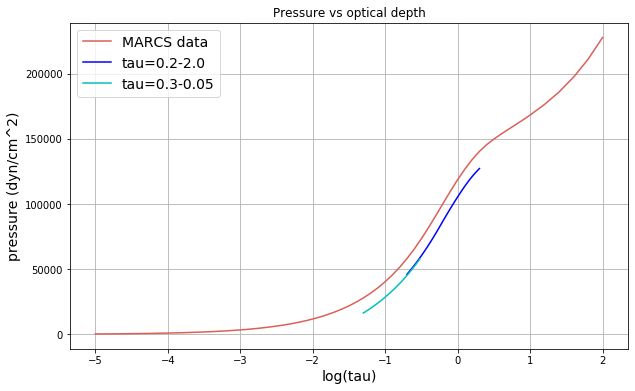

In [14]:
# Plot
MARCS_P = MARCS_P_e + MARCS_P_g + MARCS_P_rad +MARCS_P_turb #sum over all pressures
fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('log(tau)', fontsize="14")
fr.set_ylabel('pressure (dyn/cm^2)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, MARCS_P, "-", label='MARCS data')
fr.plot(np.log10(tau_02), Pprofile_02, "b-", label='tau=0.2-2.0')
fr.plot(np.log10(tau_03), Pprofile_03, "c-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Pressure vs optical depth")
show()

Discussion of plot:  
The above plot shows an increasing relation between pressure and optical depth. Pressure increases closer to the star, just as optical depth. The pressure of the MARCS model was determined by summing over all pressures [4]. The pressure profile of our model fits the MARCS model quite well, they seem to be proportional. An assumption that was made that could cause the deviation, that is the same everywhere, is the assumption that $P(\tau = 0)=0$. The optical depth is zero at the surface (as can be seen in the plot of geometrical depth vs optical depth), but the pressure is in reallity not zero there. This difference could be the reason for this offset. In addition to that, we made the assumption of no radiation pressure, only gas pressure. This could also increase the pressure to values closer to the MARCS data.

### Plot of log tau vs rho(tau)

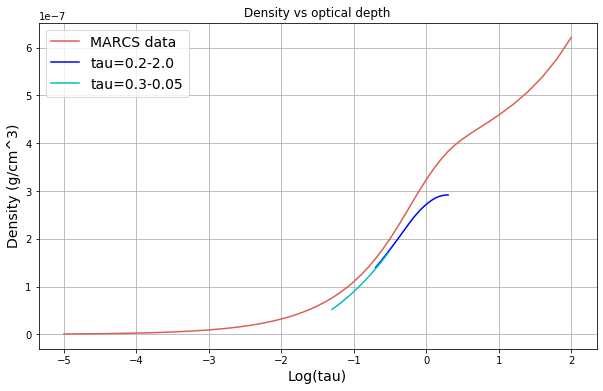

In [15]:
# Plot
MARCS_dens = rho2(MARCS_P)
fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('Log(tau)', fontsize="14")
fr.set_ylabel('Density (g/cm^3)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, MARCS_dens, "-", label='MARCS data')
fr.plot(np.log10(tau_02), rho(Pprofile_02,tau_02), "b-", label='tau=0.2-2.0')
fr.plot(np.log10(tau_03), rho(Pprofile_03,tau_03), "c-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Density vs optical depth")
show()

Discussion of plot:  
The density of the MARCS data was determined differently than that of our model. For our model the effective temperature was used with the approximation of a grey atmosphere, while for the MARCS model a $T_{eff}$ of 5777 K was taken, the literature value of the Sun's effective temperature [4] and the ideal gas law. 


### Plot of log tau vs kappa(tau)

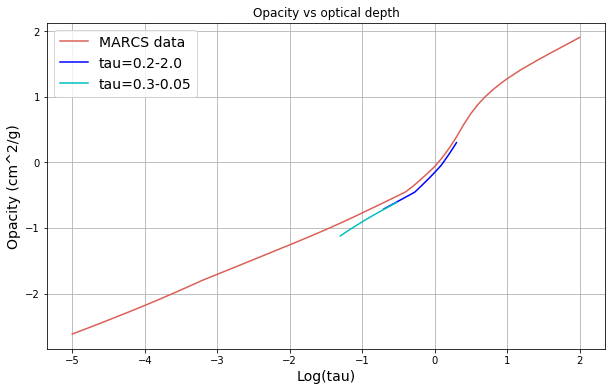

In [86]:
# Plot
#use opacity function made from combined data in part 1
MARCS_kappa = np.zeros(len(MARCS_P))
for i in range(len(MARCS_P)):
    MARCS_kappa[i] = Log_opacity(np.log10(MARCS_P[i]), np.log10(MARCS_Temp[i]))

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('Log(tau)', fontsize="14")
fr.set_ylabel('Opacity (cm^2/g)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, MARCS_kappa, "-", label='MARCS data')
fr.plot(np.log10(tau_02), kappa_02, "b-", label='tau=0.2-2.0')
fr.plot(np.log10(tau_03), kappa_03, "c-", label='tau=0.3-0.05')
fr.legend(fontsize='14')
fr.set_title("Opacity vs optical depth")
show()

Discussion of plot:  
Opacity is the capacity of matter to absorb electromagnetic radiation. This also increases with optical depth as both have as a consequence that less radiation goes through the matter. Our model relatively closely matches the MARCS data, with a slight offset that is a larger at smaller optical depths. This deviation could be caused by wrong assumptions in the starting values. Our opacity function is determined using the Opacity Project data. The small deviations in this, the deviations in the pressure and temperature profile due to the assumptions that were made could have caused this deviation.  


### Plot of log tau vs z(tau)

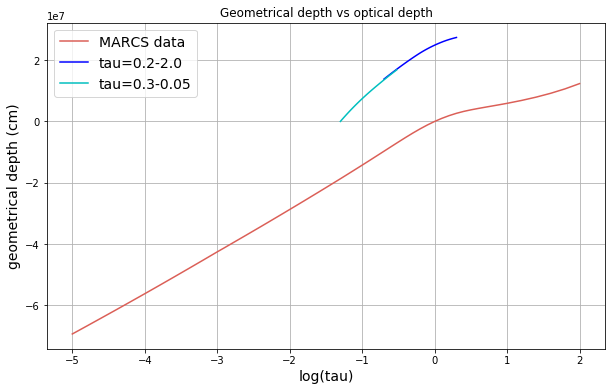

In [17]:
# Plot

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('log(tau)', fontsize="14")
fr.set_ylabel('geometrical depth (cm)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, MARCS_z, "-", label='MARCS data')
fr.plot(np.log10(tau_02), z_011, "b-", label='tau=0.2-2.0')
fr.plot(np.log10(tau_03), z_012, "c-", label='tau=0.3-0.05')
#fr.plot([np.log10(0.666)], [2.3e7], "o", label='tau=0.2-2.0') #tau=2/3, most radiation from this depth
fr.legend(fontsize='14')
fr.set_title("Geometrical depth vs optical depth")
show()

Discussion of plot:  
Our model is quite off from the MARCS data. They are both increasing with optical depth, as this depends on how one defines it. To make a function of geometrical depth we used the assumption that $z(\tau = 0.05)=0$, which could be one of the reasons for the large offset.  
The most of the radiation at the surface is coming a geometrical depth where tau=2/3 [4]. This gives log(2/3)=-0.176. In the plot this is at approximately z=2.3e7 cm. Below we also calculated this value, giving a depth of z=2.26e7 cm.

In [18]:
P066 = Solve_02.sol(2/3)[0] #pressure calculation for tau=2/3
z_066 = Solve_01.sol(P066)  #geometrical depth for P(tau=2/3)
print(f'Most radiation at the surface from z={z_066[0]} cm')

Most radiation at the surface from z=22677159.93182908 cm


## Part 4
The number density fractions that are needed to determine the ionisation fractions can be calculated using the Saha equation [4]:  

$\frac{n_{i+1}}{n_i}=\frac{1}{n_e}\left(\frac{2\pi m_ekT}{h^2}\right)^{3/2}\frac{2U_{i+1}}{U_i}e^{-\frac{E_{ion}}{kT}}$  
The number density of electrons $n_e$ can be determined using the ideal equation of state:  
$n_e = \frac{P_e}{kT}$  
Where $P_e$ is the pressure due to electrons.  
The partition functions $U$ can be determined with: $U_{ion} = \sum_{n=1}^{\infty}g_n e^{-\frac{E_n}{kT}}$  
Here we will assume the following values for $U$:  
$U_{HI} =2$, $U_{HII} = 1$, $U_{HeI} =1$, $U_{HeII} = 2$, $U_{HeIII} = 1$  
  
Using the fractions that were calculated with the Saha equations the ionisation fractions $f_i$ can be calculated.  
$f_{HI} = \frac{1}{1+\left ( {n_{HIU}}/{n_{HI}} \right )}$  
$f_{HII} = \frac{\left ( {n_{HII}}/{n_{HI}} \right )}{1+\left ( {n_{HII}}/{n_{HI}} \right )}$  
$f_{HeI} = \frac{1}{1+ (n_{HeII}/n_{HeI}) + (n_{HeIII}/n_{HeII})(n_{HeII}/n_{HeI})}$  
$f_{HeII} = \frac{n_{HeII}/n_{HeI}}{1+ (n_{HeII}/n_{HeI}) + (n_{HeIII}/n_{HeII})(n_{HeII}/n_{HeI})}$  
$f_{HeIII} = \frac{(n_{HeIII}/n_{HeII})(n_{HeII}/n_{HeI})}{1+ (n_{HeII}/n_{HeI}) + (n_{HeIII}/n_{HeII})(n_{HeII}/n_{HeI})}$  



In [85]:
# Saha function
m_e = 9.11e-28  #g, mass electron
h  = 6.6260755e-27  #erg s, planck constant
k = 1.380658e-16  #erg/K

eV_erg = 1.60218e-12  #eV to erg conversion factor

#Ionisation energies
E_HI = 13.6*eV_erg
E_HeI = 24.6*eV_erg
E_HeII = 54.4*eV_erg

T = MARCS_Temp    # Temperature [K]
P_e = MARCS_P_e    # Pressure due to electrons [dyn/cm^2]
n_e = P_e/(k*T)

def Saha(Ui, Ui1, Eion):
    """ Calculate population ratio as a function of ionisation energy and 
        partition functions using the Saha equation
    """
    p1 = (2*np.pi*m_e*k*T/h**2)**1.5
    ni1_ni = 1/n_e * p1 * 2*Ui1/Ui*np.exp(-Eion/(k*T))
    return ni1_ni

nHII_nHI = Saha(2,1, E_HI)
nHeII_nHeI = Saha(1,2, E_HeI)
nHeIII_nHeII = Saha(2,1, E_HeII)

# ionisation fraction H
fHI = 1/(1+nHII_nHI)
fHII = nHII_nHI/(1+nHII_nHI)

# ionisation fractions He
fHeI = 1/(1+nHeII_nHeI + nHeIII_nHeII*nHeII_nHeI)
fHeII = nHeII_nHeI/(1+nHeII_nHeI + nHeIII_nHeII*nHeII_nHeI)
fHeIII = nHeIII_nHeII*nHeII_nHeI/(1+nHeII_nHeI + nHeIII_nHeII*nHeII_nHeI)

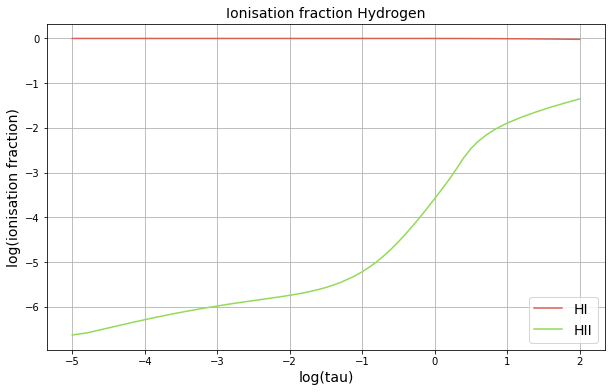

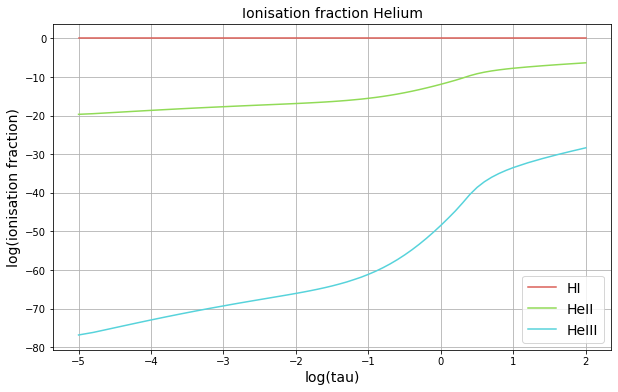

In [64]:
# Plot of hydrogen ionization fraction as function of log tau

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('log(tau)', fontsize="14")
fr.set_ylabel('log(ionisation fraction)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, np.log10(fHI), "-", label='HI')
fr.plot(MARCS_logTau, np.log10(fHII), "-", label='HII')
fr.legend(fontsize='14')
fr.set_title("Ionisation fraction Hydrogen", fontsize = '14')
show()


# Plot of the ionisation fraction of helium as a function of log tau

fig = figure(figsize=(10,6))
fr = fig.add_subplot(1,1,1)
fr.set_xlabel('log(tau)', fontsize="14")
fr.set_ylabel('log(ionisation fraction)', fontsize="14")
fr.grid(True)
fr.plot(MARCS_logTau, np.log(fHeI), "-", label='HI')
fr.plot(MARCS_logTau, np.log10(fHeII), "-", label='HeII')
fr.plot(MARCS_logTau, np.log10(fHeIII), "-", label='HeIII')
#fr.plot(MARCS_logTau, np.log10(fHeII + fHeIII), "-", label='Total')
fr.legend(fontsize='14')
fr.set_title("Ionisation fraction Helium", fontsize = '14')
show()

The ionisation fractions show what fraction of the total hydrogen or Helium abundance is ionised. Hence all the ionisation fractions in the plots should add up to one at each optical depth. These plots show that the ionisation fractions increase with optical depth. This makes sense as the number density fraction from the Saha equation increases with temperature, and as we have shown before, the temperature increases with optical depth. The ionisation fraction are relatively small compared to neutral hydrogen and helium. For hydrogen to ionisation gets up to $\approx 4$% for the highest given value of $\tau$. For the Helium the ionisation fractions are (relatively) much smaller, which can be explained by their higher ionisation energies.

## Part 5

### What would be the next step to create a model of an observed stellar spectrum?
This model has made a couple approximations which make it a less accurate representation of a stellar atmosphere. It has an assumption of no radiation pressure, a Rosseland mean opacity and a grey atmosphere. These assmptions could be exchanged for more complicated and accurate version, for a better model. With all the data and function we have now, it is possible to determine the flux of the star. This can then be used to create a spectrum. 

## References 
  
[1] N. R. Badnell et al. “Updated opacities from the Opacity Project”. In: $\textit{Monthly Notices of the RoyalAstronomical Society}$ 360.2 (June 2005), pp. 458–464.issn: 1365-2966.doi:10.1111/j.1365-2966.2005.08991.x.url:http://dx.doi.org/10.1111/j.1365-2966.2005.08991.x.
[2] N Grevesse and A Noels. “Atomic data and the spectrum of the solar photosphere”. In: $\textit{Physica Scripta}$ T47 (Jan. 1993), pp. 133–138.doi:10.1088/0031-8949/1993/t47/021.url:https://doi.org/10.1088/0031-8949/1993/t47/021.  
[3] Pauli  Virtanen  et  al.  “SciPy  1.0:  Fundamental  Algorithms  for  Scientific  Computing  in  Python”.  In: $\textit{Nature Methods}$ 17 (2020), pp. 261–272.doi:10.1038/s41592-019-0686-2.  
[4] Francis Leblanc. $\textit{An Introduction to stellar astrophysics.}$ Wiley, Cop, 2010.  